In [2]:
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import struct


# some utilities

def create_submission_file(fname, preds):
    """
    Create Kaggle submision with predictions written as a csv (comma separated values) file 
    """
    
    ofile  = open(fname, "w")
    writer = csv.writer(ofile, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)    
    
    writer.writerow(['id', 'label'])
    
    
    for i in range(preds.shape[0]):
        writer.writerow([i,preds[i]])
        

def convert_to_one_hot(batch, num_values=10):
    """
    Expects a numpy array of labels [4, 3, 0, ...]
    Outputs:
        [
            [0,0,0,0,1,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0],
            [1,0,0,0,0,0,0,0,0,0],
            ....
        ]
    """
    one_hot_labels = np.zeros((batch.size, num_values))
    one_hot_labels[np.arange(batch.size), batch] = 1
    return one_hot_labels

        
def read_MNIST(dataset = "training", path = "./", load_small=False):
    """
    reading in MNIST data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    

    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X



def show_MNIST_example(image):
    """
    Render a given numpy.uint8 array of pixel data as an image.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    plt.show()

In [21]:
scores =  np.array([[1, 2,3], [4, 5, 6], [7,8,10]])
for i in range(scores.shape[0]):
    scores[i,:] = scores[i,:] - np.max(scores[i,:])
print(scores)
softmax = np.exp(scores)
print(softmax)
for i in range(softmax.shape[0]):
    sum = np.sum(softmax[i,:])
    for j in range(3):
        softmax[i,j] = softmax[i,j]/sum
softmax

[[-2 -1  0]
 [-2 -1  0]
 [-3 -2  0]]
[[0.13533528 0.36787944 1.        ]
 [0.13533528 0.36787944 1.        ]
 [0.04978707 0.13533528 1.        ]]


array([[0.09003057, 0.24472847, 0.66524096],
       [0.09003057, 0.24472847, 0.66524096],
       [0.04201007, 0.1141952 , 0.84379473]])

In [34]:
predictions = softmax
y = np.eye(3)


In [35]:
LL_array = np.zeros(y.shape[0])
for i in range(predictions.shape[0]):
    LL_array[i] = np.dot(predictions[i],y[i])
LL = np.average(np.log(LL_array))

In [37]:
LL_array

array([0.09003057, 0.24472847, 0.84379473])

In [26]:
LL_array = np.zeros(y.shape[0])

In [28]:
for i in range(predictions.shape[0]):
        LL_array[i] = np.dot(predictions[i],y[i])


In [29]:
LL_array

array([0.09003057, 0.24472847, 0.84379473])

In [30]:
LL = np.average(np.log(LL_array))

In [33]:
np.log(LL_array)

array([-2.40760596, -1.40760596, -0.16984602])

In [38]:
predictions

array([[0.09003057, 0.24472847, 0.66524096],
       [0.09003057, 0.24472847, 0.66524096],
       [0.04201007, 0.1141952 , 0.84379473]])

In [39]:
predictions.transpose()

array([[0.09003057, 0.09003057, 0.04201007],
       [0.24472847, 0.24472847, 0.1141952 ],
       [0.66524096, 0.66524096, 0.84379473]])

In [42]:
def infer(X,w):
    """
    Compute the class scores that model w gives for each class, given data X
    With 10 classes, there would be 10 scores for each x
    """
    # w is a 2D np-array of size 784*10
    # X is a 1D np-array of size N*784
    #return scores, size N*10
    
    #check shape
    if len(X.shape) == 1 or X.shape[0] == 1 or X.shape[1] ==1:
        X = X.reshape(1,-1)
    
    
    scores = np.dot(X,w)
    
    #To avoid overflow, substrating the maximum value of each row
    for i in range(scores.shape[0]):
        scores[i,:] = scores[i,:] - np.max(scores[i,:])
    return scores

def softmax(scores):
    """
    Computes the softmax function given model scores
    
    """
    
    #return, softmax N*10 
    
    softmax = np.exp(scores)
    for i in range(softmax.shape[0]):
        sum = np.sum(softmax[i,:])
        for j in range(softmax.shape[1]):
            softmax[i,j] = softmax[i,j]/sum
    return softmax


def log_likelihood(X, w, y):
    """
    
    Inputs: 
      X: a Nxd matrix where each of the N rows is a datapont with d features
      Y: a Nx10 matrix, each row is a one-hot vector with the ith entry is 1 if that datapoint belongs to class i 
      w: is a dx10 matrix containing your model parameters
    Outputs:
      LL: a scalar containing the AVERAGE log-likelihood of the dataset's labels y, given inputs X and model w
    """
    #compute the un-normalized 'scores' of each class for each datapoint
    scores = infer(X,w)
    #normalize the scores to get a distribution over classes for each datapoint
    predictions = softmax(scores) #************* your code
    
    LL_array = np.zeros(y.shape[0])
    for i in range(predictions.shape[0]):
        LL_array[i] = np.dot(predictions[i],y[i])
    LL = np.average(np.log(LL_array))
    
    return LL


def objective(X, w, y):
    """
    Compute components of the optimization objective
    Outputs:
        logloss: value of log-loss (negative average log-likelihood)
        regularizer: value of the regularization term (Frobenius norm of w), NOT multiplied by lambda
    """
    logloss = -log_likelihood(X,w,y)
    regularizer =0
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            regularizer += w[i,j]**2
    return logloss, regularizer


def gradient(X,w,y):
    """
    Compute in grad the gradient of the log-loss of the model (w) given the features (X) and labels (y) w.r.t. w
    Also compute and return in l2grad the gradient of the regularizer lambda*norm(w)
    Note: we can't use the name 'lambda' since it's a keyword in Python
    Reminder: the full objective to be MINIMIZED is -log p(y|X;w) + lmbda*norm2(w)
    """
    
    #Compute any extra variable needed to compute the gradient:
    scores = infer(X, w)
    predictions = softmax(scores) #N*10
    #x is N*d
    #y is N*10
    #w is d*10
    #Compute the gradient of the average log-loss
    #grad = #************ your code
    
    grad = 1/X.shape[0]*(np.matmul(predictions.transpose(),X) - np.matmul(y.transpose(),X)) #10*d
    grad = grad.transpose() #d*10
    l2grad = 2*w #d*10
    
    
    return grad, l2grad



def accuracy(X,w,y):
    """
    Compute accuracy (one minus average 0/1 loss) of model w relative to true labels y on data X
    """
    y_hat = np.argmax(infer(X,w),axis=1)
    y = np.argmax(y,axis=1)
    acc = np.sum(np.equal(y,y_hat).astype(np.float32))/y.shape[0]
    return acc
    
    

Definition of the learning algorithm (minibatch SGD)

In [82]:
def minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    
    # you need to write it!
    # it will need to return the tuple (model parameters, objective value, training accuracy)
    
    #shuffle the training matrix.
    shuffling_matrix = np.random.permutation(xTr.shape[0])
    xTr = np.take(xTr,shuffling_matrix,axis=0)
    yTr = np.take(yTr,shuffling_matrix,axis=0)
    

    w = np.random.randn(xTr.shape[1],10) #d*10
    epoch = 0
    lastloss = np.Inf
    converged = False
    while True:
        epoch += 1
        it = 0
        for first in range(0,xTr.shape[0],bsize):
            it += 1

            logloss, regularizer = objective(xTr[first:first+bsize], w, yTr[first:first+bsize])
            total_loss = logloss+lmbda*regularizer
            
            grad, l2grad = gradient(xTr[first:first+bsize], w, yTr[first:first+bsize])
            total_grad = grad+lmbda*l2grad
            
            if it % 10 == 0:
                converged = epoch > maxepochs or total_loss > lastloss-objTol
                lastloss = total_loss
                if verbose==2 or verbose==1 and it % (100) == 0:
                    print('epoch %d: iter %d:  loss %.4f' %(epoch, it, total_loss))
                if converged:
                    break
            w = w - lr*total_grad # update w (only if continuing updates)
        if converged:
            break
    return w,lastloss, accuracy(xTr,w,yTr)#, accuracy(xVl,w,yVl)

In [51]:
xTr, yTr = read_MNIST('Training')
xVl, yVl = read_MNIST('Validation')

xTr, yTr, mu, sigma = preprocess_data(xTr, yTr, visualize=False)
xVl, yVl, = preprocess_data(xVl, yVl, mu, sigma, visualize=False)

In [80]:
minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0.2, lr = .1,maxepochs=10,bsize=32,objTol=.01,verbose=1)

epoch 1: iter 100:  loss 1.5907


(array([[-1.74132045e-02, -3.30540604e-02,  6.99679132e-03, ...,
         -4.58219674e-03,  3.85935073e-02, -4.49335381e-03],
        [ 2.14617133e-03,  3.12493767e-03,  4.15252294e-03, ...,
          7.53187065e-04,  1.45518178e-05,  1.76866175e-03],
        [ 2.67848402e-03, -5.71122251e-03, -1.02881126e-03, ...,
         -4.04502243e-04, -2.90275433e-03,  2.25055774e-03],
        ...,
        [-2.06439967e-04, -3.25263083e-03, -1.04656113e-03, ...,
         -4.04195552e-03,  1.15266702e-03,  1.69574174e-03],
        [ 8.33722655e-04, -4.49367992e-04,  2.56925879e-03, ...,
          3.65077922e-04,  3.23647713e-03,  1.35489306e-04],
        [-5.02040516e-04,  2.60284917e-03,  4.19663852e-03, ...,
         -1.88115280e-03,  1.24203661e-03, -1.17068974e-03]]),
 1.158715484968561,
 0.8301,
 0.8218)

Let's start our experiments by visualizing the data (you can run this even before completing any code)

Training images
Class: 5


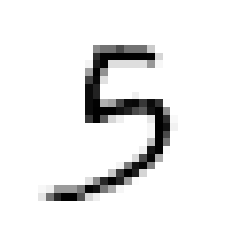

Class: 9


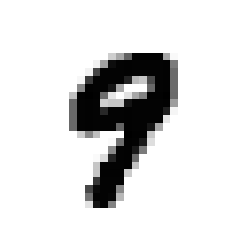

Validation images
Class: 1


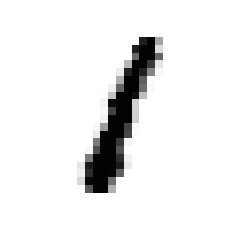

Class: 1


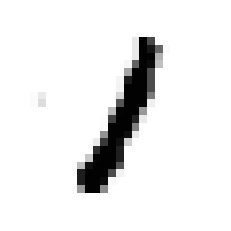

In [4]:

X,y = read_MNIST('training')
print('Training images')
print('Class: %d'%y[10])
show_MNIST_example(X[10])
print('Class: %d'%y[20])
show_MNIST_example(X[20])


X,y = read_MNIST('validation')
print('Validation images')
print('Class: %d'%y[10])
show_MNIST_example(X[10])
print('Class: %d'%y[20])
show_MNIST_example(X[20])



Before we can start experiments, we need one more piece: feature transform. In this case we are using the "raw" features (pixel values) plus the constant term, but with normalization that applies z-scoring to each pixel. 

In [5]:
# if mu and sigma are provided, they are used to normalize each pixel
# otherwise, they are computed and returned
def preprocess_data(X, y = None, mu = None, sigma = None, visualize = False):

    if visualize:
        print('VISUALIZE BEFORE NORMALIZATION')
        #Visualize example before normalization
        show_MNIST_example(X[30])
        show_MNIST_example(X[500])
    
    X = X.reshape(X.shape[0], -1)
    
    if mu is None: # need to compute normalizing stats
        compute_stats = True
        mu = X.mean(axis=0, keepdims=True)
        sigma = X.std(axis=0, keepdims=True)
        sigma[np.equal(sigma,0)] = 1.0 # avoid division by zero in case of degenerate features
    else:
        compute_stats = False
        
    #Normalize the data
    X = (X - mu) / sigma
    bias_feature = np.ones((X.shape[0],1))
    X = np.concatenate([np.ones((X.shape[0],1)),X],1)
    
    # process the labels
    if y is not None:
        y_out = np.array([convert_to_one_hot(x) for x in y]).squeeze()
    else:
        y_out = y

    if visualize:
        print('VISUALIZE AFTER NORMALIZATION')
        #Visualize example after normalization
        show_MNIST_example(X[30])
        show_MNIST_example(X[500])
    
    if compute_stats:
        return X, y_out, mu, sigma
    else:
        return X, y_out

Test it out (again, this should work without any new code)

VISUALIZE BEFORE NORMALIZATION


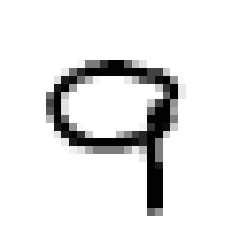

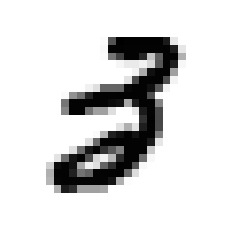

VISUALIZE AFTER NORMALIZATION


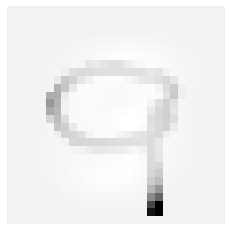

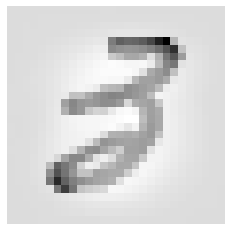

In [6]:
xTr, yTr = read_MNIST('Training')
xTr, yTr, mu, sigma = preprocess_data(xTr, yTr, visualize=True)

We now define the main routine for our experiments: load training/validation data sets, and tune the regularization parameter (and perhaps other parameters you want to tune)

In [84]:
# run minibatch SGD for every value of lambda and record training/val accuracy
def tune_regularization(xTr, yTr, xVl, yVl, lambdas, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for lmbda in lambdas:
        model[lmbda], obj[lmbda], trAcc[lmbda] = minibatch_sgd(
                xTr, yTr, xVl, yVl, lmbda, sgd_opt['lr'], sgd_opt['maxepochs'], sgd_opt['bsize'], verbose=sgd_opt['verbose'])
        valAcc[lmbda] = accuracy(xVl,model[lmbda],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,valAcc[lmbda],trAcc[lmbda]))
        
    return model, obj, trAcc, valAcc

Below is the code for running the experiment and selecting the best model/parameters based on the hyperparameter tuning.

In [85]:
xTr, yTr = read_MNIST('Training')
xVl, yVl = read_MNIST('Validation')

xTr, yTr, mu, sigma = preprocess_data(xTr, yTr, visualize=False)
xVl, yVl, = preprocess_data(xVl, yVl, mu, sigma, visualize=False)

# values below are a recommendation for initial exploration -- you should see if you want to refine these

lambdas = [0,.0001,.001,.005,.050,.01,.1,1.0,10.0]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':16, 'maxepochs':20, 'lr':.1,'verbose':0}


model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- lambda=0.00000, val Acc = 0.4924  (tr Acc = 0.4914)
-------------- lambda=0.00010, val Acc = 0.3545  (tr Acc = 0.3507)
-------------- lambda=0.00100, val Acc = 0.3562  (tr Acc = 0.3522)
-------------- lambda=0.00500, val Acc = 0.4019  (tr Acc = 0.4109)
-------------- lambda=0.05000, val Acc = 0.7933  (tr Acc = 0.7978)
-------------- lambda=0.01000, val Acc = 0.5924  (tr Acc = 0.5937)
-------------- lambda=0.10000, val Acc = 0.8195  (tr Acc = 0.8313)
-------------- lambda=1.00000, val Acc = 0.6907  (tr Acc = 0.6964)
-------------- lambda=10.00000, val Acc = 0.1144  (tr Acc = 0.1158)
0.1


From above testing result, when lambda is 0.05 and 0.1, the validation accuracy is the highest, Additional testing with regarding more fine tuned lambda value lambda = np.arange(0.1,0.55,0.05)

In [92]:
lambdas = np.arange(0.1,0.55,0.05)
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':16, 'maxepochs':20, 'lr':.1,'verbose':0}


model, obj, trAcc, valAcc = tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- lambda=0.10000, val Acc = 0.8079  (tr Acc = 0.8138)
-------------- lambda=0.15000, val Acc = 0.8197  (tr Acc = 0.8198)
-------------- lambda=0.20000, val Acc = 0.8036  (tr Acc = 0.8055)
-------------- lambda=0.25000, val Acc = 0.7832  (tr Acc = 0.7817)
-------------- lambda=0.30000, val Acc = 0.7704  (tr Acc = 0.7776)
-------------- lambda=0.35000, val Acc = 0.7478  (tr Acc = 0.7511)
-------------- lambda=0.40000, val Acc = 0.7449  (tr Acc = 0.7390)
-------------- lambda=0.45000, val Acc = 0.7478  (tr Acc = 0.7539)
-------------- lambda=0.50000, val Acc = 0.7284  (tr Acc = 0.7322)
0.15000000000000002


From the fine tunning of lambda value, the lambda 0.15 has the best validation accuracy. difference between 0.1,0.15,0.2 is very minimal.

In [102]:
def lr_tune_regularization(xTr, yTr, xVl, yVl, lrs, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for lr in lrs:
        model[lr], obj[lr], trAcc[lr] = minibatch_sgd(
                xTr, yTr, xVl, yVl, sgd_opt['lmbda'], lr, sgd_opt['maxepochs'], sgd_opt['bsize'], verbose=sgd_opt['verbose'])
        valAcc[lr] = accuracy(xVl,model[lr],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lr=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lr,valAcc[lr],trAcc[lr]))
        
    return model, obj, trAcc, valAcc

In [103]:
lrs = [.001,.005,.01,.05,.1,.5,1.0]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':16, 'maxepochs':20, 'lmbda':.15,'verbose':1}


model, obj, trAcc, valAcc = lr_tune_regularization(xTr,yTr,xVl,yVl,lrs,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- lr=0.00100, val Acc = 0.1002  (tr Acc = 0.1075)
epoch 1: iter 100:  loss 907.0028
epoch 1: iter 200:  loss 660.3497
epoch 1: iter 300:  loss 487.3170
epoch 1: iter 400:  loss 362.0697
-------------- lr=0.00500, val Acc = 0.3915  (tr Acc = 0.3946)
epoch 1: iter 100:  loss 655.1959
epoch 1: iter 200:  loss 352.0620
-------------- lr=0.01000, val Acc = 0.4273  (tr Acc = 0.4230)
epoch 1: iter 100:  loss 59.8967
epoch 1: iter 200:  loss 3.9676
-------------- lr=0.05000, val Acc = 0.8185  (tr Acc = 0.8254)
epoch 1: iter 100:  loss 4.1874
-------------- lr=0.10000, val Acc = 0.8024  (tr Acc = 0.8052)
-------------- lr=0.50000, val Acc = 0.5785  (tr Acc = 0.5789)
-------------- lr=1.00000, val Acc = 0.4785  (tr Acc = 0.4822)
0.05


Out of all the learning rates, learning rate of 0.1 and 0.05 performed the best with validation accuracy of 0.8024 and 8185 respectively, Therefore, learning rate of 0.05 is picked.

In [106]:
def tol_tune_regularization(xTr, yTr, xVl, yVl, tols, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for tol in tols:
        model[tol], obj[tol], trAcc[tol] = minibatch_sgd(
                xTr, yTr, xVl, yVl, sgd_opt['lmbda'],sgd_opt['lr'] , sgd_opt['maxepochs'], sgd_opt['bsize'], objTol=tol,verbose=sgd_opt['verbose'])
        valAcc[tol] = accuracy(xVl,model[tol],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- tol=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(tol,valAcc[tol],trAcc[tol]))
        
    return model, obj, trAcc, valAcc

In [107]:
tols = [.0001,.0005,.001,.005,.01,.05,.1]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':16, 'maxepochs':20, 'lmbda':.15,'lr':0.05,'verbose':1}


model, obj, trAcc, valAcc = tol_tune_regularization(xTr,yTr,xVl,yVl,tols,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

epoch 1: iter 100:  loss 58.8636
epoch 1: iter 200:  loss 4.4266
-------------- tol=0.00010, val Acc = 0.8335  (tr Acc = 0.8357)
epoch 1: iter 100:  loss 57.5106
epoch 1: iter 200:  loss 3.4363
-------------- tol=0.00050, val Acc = 0.8403  (tr Acc = 0.8449)
epoch 1: iter 100:  loss 60.7433
-------------- tol=0.00100, val Acc = 0.8200  (tr Acc = 0.8248)
epoch 1: iter 100:  loss 57.6339
epoch 1: iter 200:  loss 3.2551
-------------- tol=0.00500, val Acc = 0.8218  (tr Acc = 0.8275)
epoch 1: iter 100:  loss 57.8198
epoch 1: iter 200:  loss 3.4391
-------------- tol=0.01000, val Acc = 0.8373  (tr Acc = 0.8474)
epoch 1: iter 100:  loss 59.5267
epoch 1: iter 200:  loss 3.5803
-------------- tol=0.05000, val Acc = 0.8338  (tr Acc = 0.8385)
epoch 1: iter 100:  loss 59.5665
epoch 1: iter 200:  loss 3.3498
-------------- tol=0.10000, val Acc = 0.8131  (tr Acc = 0.8234)
0.0005


Out of all the tolerance picked, tol = 0.0005 gives out the best performance with validation accuracy of 0.8403, therefore tol=0.0005 is picked

In [108]:
def bs_tune_regularization(xTr, yTr, xVl, yVl, bss, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for bs in bss:
        model[bs], obj[bs], trAcc[bs] = minibatch_sgd(
                xTr, yTr, xVl, yVl, sgd_opt['lmbda'],sgd_opt['lr'] , sgd_opt['maxepochs'], bs , objTol=sgd_opt['tol'],verbose=sgd_opt['verbose'])
        valAcc[bs] = accuracy(xVl,model[bs],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- bs=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(bs,valAcc[bs],trAcc[bs]))
        
    return model, obj, trAcc, valAcc

In [110]:
bss = [10,50,100,500,750,1000]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'maxepochs':20, 'lmbda':.15,'lr':0.05,'tol':0.0005,'verbose':1}


model, obj, trAcc, valAcc = bs_tune_regularization(xTr,yTr,xVl,yVl,bss,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

epoch 1: iter 100:  loss 56.8725
epoch 1: iter 200:  loss 3.7255
-------------- bs=10.00000, val Acc = 0.8074  (tr Acc = 0.8165)
epoch 1: iter 100:  loss 60.1623
epoch 1: iter 200:  loss 3.6131
-------------- bs=50.00000, val Acc = 0.8678  (tr Acc = 0.8738)
epoch 1: iter 100:  loss 58.1490
epoch 1: iter 200:  loss 3.3438
-------------- bs=100.00000, val Acc = 0.8745  (tr Acc = 0.8837)
-------------- bs=500.00000, val Acc = 0.8774  (tr Acc = 0.8853)
-------------- bs=750.00000, val Acc = 0.8783  (tr Acc = 0.8844)
-------------- bs=1000.00000, val Acc = 0.8763  (tr Acc = 0.8848)
750


From all the batch size picked , even though larger minibatch size have a higher validation accuracy, but it took significantly longer time to compute. Additionally, the accuracy only increased marginally since batch size >100, going to pick the batch size as 100.

The final model is with lambda=0.15, learning rate = 0.05, batch size=100, tolerance=0.0005.

Finally, once you have settled on a model, you run it on test Xs and produce your prediction, which can be submitted to Kaggle.

In [123]:
model_best,obj_best,tracc_best = minibatch_sgd(xTr, yTr, xVl, yVl,
                                               lmbda=0.15, lr = .05, maxepochs=10, bsize=100,
                                               objTol=0.0005,verbose=1)

epoch 1: iter 100:  loss 58.4445
epoch 1: iter 200:  loss 3.4151
epoch 2: iter 100:  loss 0.9366


In [124]:
valAcc_best = accuracy(xVl,model_best,yVl)

In [129]:
tracc_best

0.8839

The model with 0.8763 validation accuracy and 0.8839 training accuracy

In [135]:
def compute_confusion(train_preds,train_labels):
    conf_m = np.zeros([10,10])
    for i in range(train_labels.shape[0]):
        if train_labels[i] == train_preds[i]:
            conf_m[train_labels[i],train_labels[i]] += 1
        else:
            conf_m[train_labels[i],train_preds[i]] += 1
    return conf_m

***********************************************************
printing stats for the large dataset
confusion matrix for training
[[1891.    2.   14.    8.    5.   31.   34.    2.    9.    4.]
 [   1. 1936.   10.    3.    2.    9.    4.    6.   28.    1.]
 [  17.   45. 1659.   52.   41.    5.   68.   49.   57.    7.]
 [   9.   39.   42. 1735.    1.   55.   17.   36.   39.   27.]
 [   4.   31.    8.    0. 1833.    4.   19.   10.   14.   77.]
 [  39.   47.   12.   91.   36. 1635.   37.   12.   50.   41.]
 [  16.   18.   16.    0.   12.   39. 1893.    2.    4.    0.]
 [   7.   62.   15.    9.   31.    2.    2. 1815.    3.   54.]
 [  21.  151.   27.   78.   20.   61.   10.    9. 1578.   45.]
 [  20.   30.    8.   36.   91.    4.    2.   89.   17. 1703.]]
train accuracy is printed
88.39
confusion matrix for validation dataset
[[940.   0.   5.   6.   7.  14.  19.   1.   6.   2.]
 [  0. 969.   7.   4.   2.   1.   5.   3.   9.   0.]
 [  9.  36. 831.  21.  15.   1.  39.  15.  32.   1.]
 [  5.  23.

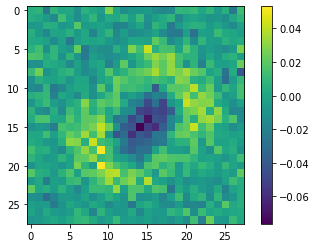

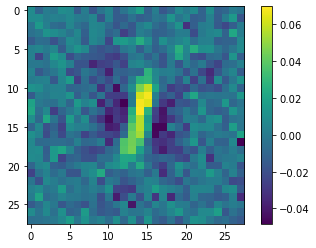

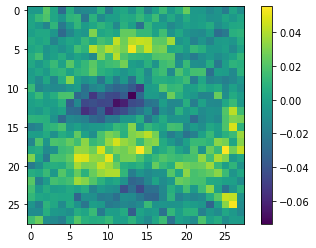

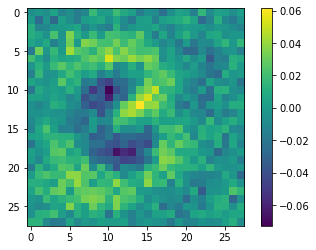

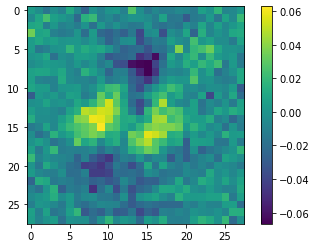

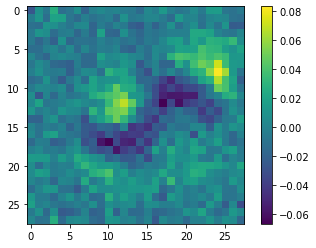

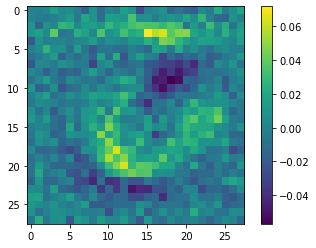

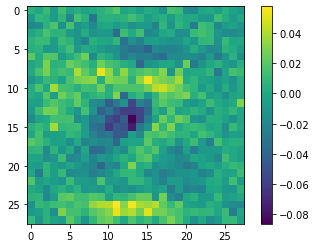

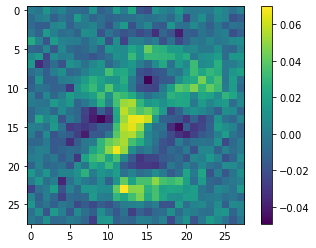

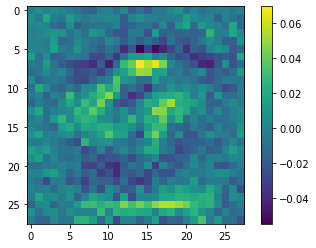

In [141]:
xTe = read_MNIST('testing')
xTe, _ = preprocess_data(xTe, None, mu, sigma, visualize=False)

#Decide which model you want to use for your submission
chosen_model = model_best

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)

#*************************************************
#computing the training statistics starts from here
#*************************************************

#predicting on train data
train_preds = np.argmax(infer(xTr,chosen_model),axis =1)

#collecting the train labels
train_labels = np.argmax(yTr,axis =1)

#computing the confusion matrix for train error
confusion_matrix_train = compute_confusion(train_preds,train_labels)

#getting the nuber of correctly classified  training points
correct_classified_pts_train = np.trace(confusion_matrix_train)

#train accuracy is being computed
train_accuracy = (correct_classified_pts_train/float(train_preds.shape[0]))*100

#*****************************************************
#computing the validation statistics starts from here
#*****************************************************
np.set_printoptions(suppress=True)
#the validation predictions are being collected
val_preds = np.argmax(infer(xVl,chosen_model),axis =1)

#the actual labels for validation are being collected
y_label = np.argmax(yVl,axis = 1)

#confusion matrix is being computed for validation data
confusion_matrix_val = compute_confusion(val_preds, y_label)

#getting the nuber of correctly classified valdidation points
correct_classified_pts_val = np.trace(confusion_matrix_val)

#valiation accuracy is being computed
validation_accuracy = (correct_classified_pts_val/float(val_preds.shape[0]))*100

print ("***********************************************************")
print ("printing stats for the large dataset")

print ("confusion matrix for training")
print (confusion_matrix_train)

print ("train accuracy is printed")
print (train_accuracy)

#confusion matrix is being printed
print ("confusion matrix for validation dataset")
print (confusion_matrix_val)

#printing the validation accuracy
print ("validation accuracy is printed")
print (validation_accuracy)


print ("printing the weights")

w = chosen_model
for i in range(10):
    plt.imshow(w[1:,i].reshape(28,28))
    #plt.imshow(w[-28**:, c].reshape(28, 28))
    plt.colorbar()
    plt.show()
create_submission_file('./large_submission.csv', final_preds)

You can now repeat the experiment on the \emph{small} training set; take care to change/rename things if you are cutting and pasting!

From the image show of wc, the higher value within wc sort of have the shape of the digits. For example, for digit 0, clearly there is an circle to be seen.For digit, 0,1,2,3,8,9, an approximate digit shape can be seen from wc. On contrast to those digits, digit 4,5,6,7 is more on the partial features, where digit 4 can seen two straight lines, and digit 5 for the start of the digits. I believe those digits are harder to differentiate to the rest of the digits, therefore the weight of wc emphasized on the special feature of those digits.

In [165]:
xTr, yTr = read_MNIST('Training',load_small = True)
xTr, yTr, mu, sigma = preprocess_data(xTr, yTr, visualize=False)


# values below are a recommendation for initial exploration -- you should see if you want to refine these



In [146]:
yTr.shape

(60, 10)

In [166]:
def sm_minibatch_sgd(xTr, yTr, xVl, yVl, lmbda=0, lr = .01,maxepochs=10,bsize=32,objTol=.01,verbose=1):
    
    # you need to write it!
    # it will need to return the tuple (model parameters, objective value, training accuracy)
    
    #shuffle the training matrix.
    shuffling_matrix = np.random.permutation(xTr.shape[0])
    xTr = np.take(xTr,shuffling_matrix,axis=0)
    yTr = np.take(yTr,shuffling_matrix,axis=0)
    

    w = np.random.randn(xTr.shape[1],10) #d*10
    epoch = 0
    lastloss = np.Inf
    converged = False
    while True:
        epoch += 1
        it = 0
        for first in range(0,xTr.shape[0],bsize):
            it += 1

            logloss, regularizer = objective(xTr[first:first+bsize], w, yTr[first:first+bsize])
            total_loss = logloss+lmbda*regularizer
            
            grad, l2grad = gradient(xTr[first:first+bsize], w, yTr[first:first+bsize])
            total_grad = grad+lmbda*l2grad
            
            if it % 1 == 0:
                converged = epoch > maxepochs or total_loss > lastloss-objTol
                lastloss = total_loss
                if verbose==2 or verbose==1 and it % (10) == 0:
                    print('epoch %d: iter %d:  loss %.4f' %(epoch, it, total_loss))
                if converged:
                    break
            w = w - lr*total_grad # update w (only if continuing updates)
        if converged:
            break
    return w,lastloss, accuracy(xTr,w,yTr)#, accuracy(xVl,w,yVl)

In [167]:
def sm_tune_regularization(xTr, yTr, xVl, yVl, lambdas, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for lmbda in lambdas:

        model[lmbda], obj[lmbda], trAcc[lmbda] = sm_minibatch_sgd(
                xTr, yTr, xVl, yVl, lmbda, sgd_opt['lr'], sgd_opt['maxepochs'], sgd_opt['bsize'], verbose=sgd_opt['verbose'])
        valAcc[lmbda] = accuracy(xVl,model[lmbda],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lambda=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lmbda,valAcc[lmbda],trAcc[lmbda]))
        
    return model, obj, trAcc, valAcc

In [168]:
lambdas = [0,.0001,.001,.005,.050,.01,.1,1.0,10.0]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':10, 'maxepochs':20, 'lr':.1,'verbose':1}


model, obj, trAcc, valAcc = sm_tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- lambda=0.00000, val Acc = 0.1319  (tr Acc = 0.1167)
-------------- lambda=0.00010, val Acc = 0.0881  (tr Acc = 0.0667)
-------------- lambda=0.00100, val Acc = 0.0956  (tr Acc = 0.1500)
-------------- lambda=0.00500, val Acc = 0.1179  (tr Acc = 0.0833)
-------------- lambda=0.05000, val Acc = 0.1187  (tr Acc = 0.0667)
-------------- lambda=0.01000, val Acc = 0.0713  (tr Acc = 0.1000)
-------------- lambda=0.10000, val Acc = 0.5256  (tr Acc = 1.0000)
-------------- lambda=1.00000, val Acc = 0.5946  (tr Acc = 0.9333)
-------------- lambda=10.00000, val Acc = 0.1322  (tr Acc = 0.1333)
1.0


In [169]:
lambdas = np.arange(0.1,1,0.1)
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':10, 'maxepochs':20, 'lr':.1,'verbose':1}


model, obj, trAcc, valAcc = sm_tune_regularization(xTr,yTr,xVl,yVl,lambdas,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- lambda=0.10000, val Acc = 0.5409  (tr Acc = 1.0000)
-------------- lambda=0.20000, val Acc = 0.6450  (tr Acc = 1.0000)
-------------- lambda=0.30000, val Acc = 0.6479  (tr Acc = 1.0000)
-------------- lambda=0.40000, val Acc = 0.6549  (tr Acc = 1.0000)
-------------- lambda=0.50000, val Acc = 0.6515  (tr Acc = 1.0000)
-------------- lambda=0.60000, val Acc = 0.6561  (tr Acc = 1.0000)
-------------- lambda=0.70000, val Acc = 0.6442  (tr Acc = 0.9833)
-------------- lambda=0.80000, val Acc = 0.6662  (tr Acc = 0.9833)
-------------- lambda=0.90000, val Acc = 0.6171  (tr Acc = 0.9333)
0.8


At lambda = 0.8 produce the best result with validation accuracy of  0.66

In [171]:
def sm_lr_tune_regularization(xTr, yTr, xVl, yVl, lrs, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for lr in lrs:
        model[lr], obj[lr], trAcc[lr] = sm_minibatch_sgd(
                xTr, yTr, xVl, yVl, sgd_opt['lmbda'], lr, sgd_opt['maxepochs'], sgd_opt['bsize'], verbose=sgd_opt['verbose'])
        valAcc[lr] = accuracy(xVl,model[lr],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- lr=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(lr,valAcc[lr],trAcc[lr]))
        
    return model, obj, trAcc, valAcc

In [172]:
lrs = [.001,.005,.01,.05,.1,.5,1.0]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':10, 'maxepochs':20, 'lmbda':0.8,'verbose':1}


model, obj, trAcc, valAcc = sm_lr_tune_regularization(xTr,yTr,xVl,yVl,lrs,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- lr=0.00100, val Acc = 0.0806  (tr Acc = 0.1000)
-------------- lr=0.00500, val Acc = 0.1632  (tr Acc = 0.2667)
-------------- lr=0.01000, val Acc = 0.3508  (tr Acc = 0.8333)
-------------- lr=0.05000, val Acc = 0.6512  (tr Acc = 1.0000)
-------------- lr=0.10000, val Acc = 0.6631  (tr Acc = 1.0000)
-------------- lr=0.50000, val Acc = 0.2457  (tr Acc = 0.3167)
-------------- lr=1.00000, val Acc = 0.1844  (tr Acc = 0.2833)
0.1


learning rate of 0.1 gives the best result of validation accuracy of 0.64

In [161]:
def sm_tol_tune_regularization(xTr, yTr, xVl, yVl, tols, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for tol in tols:
        model[tol], obj[tol], trAcc[tol] = sm_minibatch_sgd(
                xTr, yTr, xVl, yVl, sgd_opt['lmbda'],sgd_opt['lr'] , sgd_opt['maxepochs'], sgd_opt['bsize'], objTol=tol,verbose=sgd_opt['verbose'])
        valAcc[tol] = accuracy(xVl,model[tol],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- tol=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(tol,valAcc[tol],trAcc[tol]))
        
    return model, obj, trAcc, valAcc

In [173]:
tols = [.0001,.0005,.001,.005,.01,.05,.1]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'bsize':10, 'maxepochs':20, 'lmbda':0.8,'lr':0.1,'verbose':1}


model, obj, trAcc, valAcc = sm_tol_tune_regularization(xTr,yTr,xVl,yVl,tols,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- tol=0.00010, val Acc = 0.5976  (tr Acc = 0.9667)
-------------- tol=0.00050, val Acc = 0.6093  (tr Acc = 0.9833)
-------------- tol=0.00100, val Acc = 0.6654  (tr Acc = 0.9500)
-------------- tol=0.00500, val Acc = 0.5943  (tr Acc = 0.9833)
-------------- tol=0.01000, val Acc = 0.6158  (tr Acc = 0.9667)
-------------- tol=0.05000, val Acc = 0.6410  (tr Acc = 0.9667)
-------------- tol=0.10000, val Acc = 0.6683  (tr Acc = 0.9833)
0.1


among all the tolerance, there are no big differences, pick 0.001

In [163]:
def sm_bs_tune_regularization(xTr, yTr, xVl, yVl, bss, sgd_opt):
    
    obj = dict()
    trAcc = dict()
    model = dict()
    valAcc = dict()

    for bs in bss:
        model[bs], obj[bs], trAcc[bs] = sm_minibatch_sgd(
                xTr, yTr, xVl, yVl, sgd_opt['lmbda'],sgd_opt['lr'] , sgd_opt['maxepochs'], bs , objTol=sgd_opt['tol'],verbose=sgd_opt['verbose'])
        valAcc[bs] = accuracy(xVl,model[bs],yVl)
        if sgd_opt['verbose'] >= 0:
            print('-------------- bs=%.5f, val Acc = %.4f  (tr Acc = %.4f)'%(bs,valAcc[bs],trAcc[bs]))
        
    return model, obj, trAcc, valAcc

In [174]:
bss = [10,20,30,40,50]
# note: we will collect the hyperparameters governing the behavior of SGD and pass them as
# a dictionary. Feel free to add to this.
sgd_opt = {'maxepochs':20, 'lmbda':0.8,'lr':0.1,'tol':0.001,'verbose':1}


model, obj, trAcc, valAcc = sm_bs_tune_regularization(xTr,yTr,xVl,yVl,bss,sgd_opt)
#*************** write code to select best model
best = [sorted(valAcc.items() ,key = lambda x:x[1])][0][-1][0]
print(best)

-------------- bs=10.00000, val Acc = 0.6246  (tr Acc = 1.0000)
-------------- bs=20.00000, val Acc = 0.6565  (tr Acc = 1.0000)
-------------- bs=30.00000, val Acc = 0.6535  (tr Acc = 1.0000)
-------------- bs=40.00000, val Acc = 0.6388  (tr Acc = 1.0000)
-------------- bs=50.00000, val Acc = 0.6190  (tr Acc = 1.0000)
20


batch size does not have big effect on the performance. pick 20 instead. At the end, the traing accuracy is 1, which is the model can fully map the training data.

Due to the limit of the datasize, the model trained does not have a high performance, therefore a large lambda value could reduce bias thus reduce overall loss. The lambda value is the big difference between training big dataset and small dataset.

In [185]:
for key in model.keys():
    print(key)

10
20
30
40
50


In [187]:
model[20]

array([[-0.00880008, -0.01158974, -0.00209696, ..., -0.00917167,
         0.00276754,  0.0019314 ],
       [-0.00324156, -0.00558328,  0.00131978, ..., -0.00512055,
         0.0013037 , -0.0019202 ],
       [ 0.00258423, -0.00065183,  0.00211798, ...,  0.00441631,
         0.00054771,  0.00373418],
       ...,
       [ 0.00121307,  0.00154748,  0.00086559, ...,  0.00377809,
        -0.00018719,  0.0009187 ],
       [-0.01026999,  0.0024714 , -0.00323135, ..., -0.00363702,
         0.00349938,  0.0012828 ],
       [-0.00191817, -0.00041899, -0.00523426, ...,  0.00401607,
         0.00307446,  0.00229593]])

***********************************************************
printing stats for the large dataset
confusion matrix for training
[[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 6. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 6. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 6. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 6. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 6. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 6. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 6. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 6.]]
train accuracy is printed
100.0
confusion matrix for validation dataset
[[904.   3.  10.  31.   6.  17.  21.   1.   1.   6.]
 [  1. 971.   7.   1.   1.  14.   3.   1.   0.   1.]
 [ 31.  73. 730.  92.   9.   6.  29.   8.  16.   6.]
 [ 16.  80.  61. 567.   6. 138.   2.  11.  54.  65.]
 [  0.  71.  17.   1. 481.   8.  29.  20.  12. 361.]
 [119. 144.  10. 111.  13. 329.  31.  16. 169.  58.]
 [ 26.  74.  14.  17.  23.  37. 807.   0.   1.   1.]
 [  5.  48.   8.   2.  71.  25.   1. 620.   0. 220.]
 [ 54. 175.  30.  24.  11. 102.  11.  14. 473.

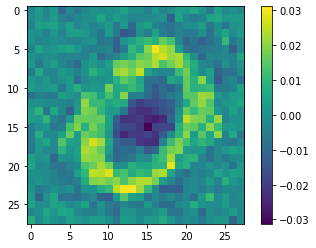

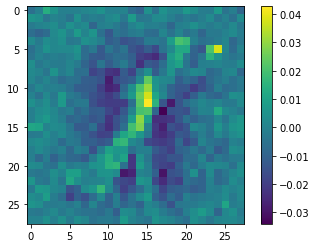

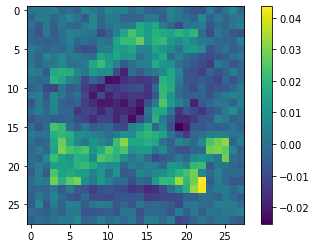

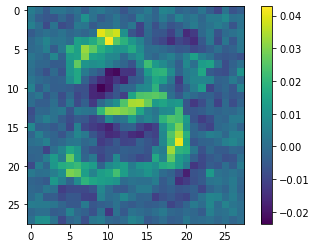

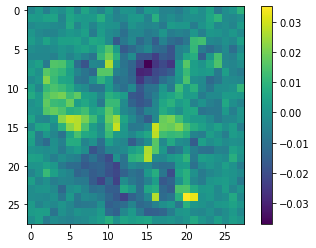

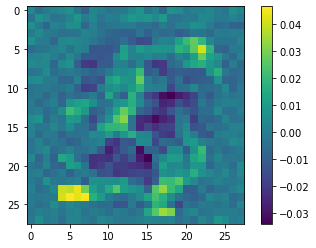

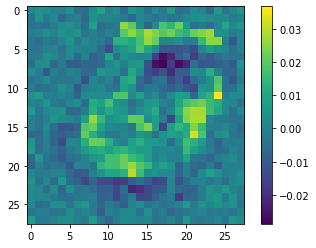

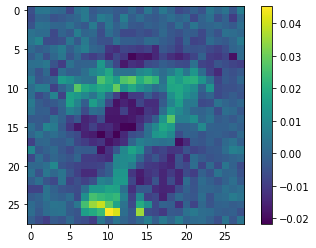

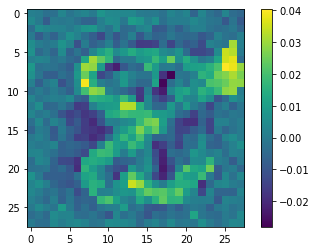

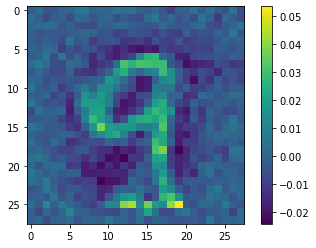

In [188]:
xTe = read_MNIST('testing')
xTe, _ = preprocess_data(xTe, None, mu, sigma, visualize=False)

#Decide which model you want to use for your submission
chosen_model = model[best]

#Make predictions and write them to a csv file
final_preds = np.argmax(infer(xTe,chosen_model),axis=1)

#*************************************************
#computing the training statistics starts from here
#*************************************************

#predicting on train data
train_preds = np.argmax(infer(xTr,chosen_model),axis =1)

#collecting the train labels
train_labels = np.argmax(yTr,axis =1)

#computing the confusion matrix for train error
confusion_matrix_train = compute_confusion(train_preds,train_labels)

#getting the nuber of correctly classified  training points
correct_classified_pts_train = np.trace(confusion_matrix_train)

#train accuracy is being computed
train_accuracy = (correct_classified_pts_train/float(train_preds.shape[0]))*100

#*****************************************************
#computing the validation statistics starts from here
#*****************************************************
np.set_printoptions(suppress=True)
#the validation predictions are being collected
val_preds = np.argmax(infer(xVl,chosen_model),axis =1)

#the actual labels for validation are being collected
y_label = np.argmax(yVl,axis = 1)

#confusion matrix is being computed for validation data
confusion_matrix_val = compute_confusion(val_preds, y_label)

#getting the nuber of correctly classified valdidation points
correct_classified_pts_val = np.trace(confusion_matrix_val)

#valiation accuracy is being computed
validation_accuracy = (correct_classified_pts_val/float(val_preds.shape[0]))*100

print ("***********************************************************")
print ("printing stats for the large dataset")

print ("confusion matrix for training")
print (confusion_matrix_train)

print ("train accuracy is printed")
print (train_accuracy)

#confusion matrix is being printed
print ("confusion matrix for validation dataset")
print (confusion_matrix_val)

#printing the validation accuracy
print ("validation accuracy is printed")
print (validation_accuracy)


print ("printing the weights")

w = chosen_model
for i in range(10):
    plt.imshow(w[1:,i].reshape(28,28))
    #plt.imshow(w[-28**:, c].reshape(28, 28))
    plt.colorbar()
    plt.show()
create_submission_file('./small_submission.csv', final_preds)